# CASC playground notebook + paper notes

## Summary

we can use node covariates to cluster better. We can get an upper bound on misclustering rate with a joint mixture model. Casc is usually better than both normal spectral clustering and canonical correlation analysis.

## Introduction

studying relationships in structured data is important.

A common approach to this is to find clusters in structured data.

Common methods to finding node clusters include bayesian, MLE, and spectral approaches. MLE is more interpretable, spectral is usually more accurate for sparse graphs and is computationally feasible for large graphs, bayesian is most flexible.

Nodes are also associated with additional measurements a lot of the time (age if the nodes are people, for instance). We can use these measurements to cluster better. They also help hella for interpreting clusters.

This is not a new idea, but most older methods don't provide any statistical guarantees. Bayesian methods eat categorical data and are computationally expensive. Other methods are kinda random and do a bunch of stuff, but don't give statistical guarantees. This paper gives the first one, as far as we can tell.

this work is a spectral approach, but it's better. Assortive CASC can do this by adding the covariance matrix of the node covariates to the regularized graph Laplacian. CASC uses the square of the regularized graph Laplacian, which is more general. It also uses a tuning parameter to balance out the contribution of the Laplacian and the covariance matrix in determining clustering.

We get the statistical guarantee by defining the node-contextualized sbm, which combines the sbm with a block-mixture model for node covariates. From this we can get a bound on casc's misclustering rate.

Canonical correlation analysis is worse than casc (if covariates are Bernoulli), but it's faster and doesn't require tuning. Our tuning parameter can have a reasonable default value though (e.g., the within-cluster sum-of-squares).

## Methodology

array([[0.        , 0.03768844, 0.03919456, 0.        , 0.03841938],
       [0.03768844, 0.        , 0.03919456, 0.03768844, 0.03841938],
       [0.03919456, 0.03919456, 0.        , 0.03919456, 0.03995471],
       [0.        , 0.03768844, 0.03919456, 0.        , 0.03841938],
       [0.03841938, 0.03841938, 0.03995471, 0.03841938, 0.        ]])

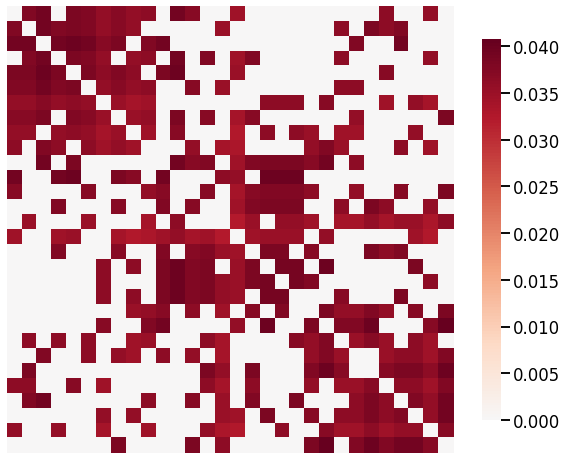

In [88]:
# gonna do this in code as I read
import numpy as np
import graspologic as gs
from graspologic.simulations import sbm
from graspologic.plot import heatmap

n = 10
p, q = .9, .3
B = np.array([[p, q, q], 
              [q, p, q],
              [q, q, p]])

B2 = np.array([[q, p, p], 
               [p, q, p],
               [p, p, q]])

A, labels = sbm([n, n, n], B, return_labels=True)
N = A.shape[0]
L = gs.utils.to_laplace(A, form='R-DAD')

heatmap(L)
L[:5, :5]

In [89]:
d = A.sum(axis=0)
tau = (1/A.shape[0]) * np.sum(d)

D = np.diag(1/np.sqrt(d + tau))
(D @ A @ D)[:5, :5]

array([[0.        , 0.03768844, 0.03919456, 0.        , 0.03841938],
       [0.03768844, 0.        , 0.03919456, 0.03768844, 0.03841938],
       [0.03919456, 0.03919456, 0.        , 0.03919456, 0.03995471],
       [0.        , 0.03768844, 0.03919456, 0.        , 0.03841938],
       [0.03841938, 0.03841938, 0.03995471, 0.03841938, 0.        ]])

In [90]:
L[:5, :5]

array([[0.        , 0.03768844, 0.03919456, 0.        , 0.03841938],
       [0.03768844, 0.        , 0.03919456, 0.03768844, 0.03841938],
       [0.03919456, 0.03919456, 0.        , 0.03919456, 0.03995471],
       [0.        , 0.03768844, 0.03919456, 0.        , 0.03841938],
       [0.03841938, 0.03841938, 0.03995471, 0.03841938, 0.        ]])

#### covariate matrix

each node has bounded covariate vector $X_i \in [-J,J]^R$  
$X \in [-J, J]^{N \times R}$ is the covariate matrix where each row corresponds to a node covariate vector

In [87]:
# generate a reasonable covariate matrix for A.
# in the kth block, the probability of the kth covariate being 1 is m1
# and the probability of the other covariates being 1 is m2
m1 = .9
m2 = .1

M = np.array([[m1, m2, m2],
              [m2, m1, m2],
              [m2, m2, m1]])

np.random.choice([0, 1], )

0